In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import bento as bt

%matplotlib inline

# Load condensate density data

In [2]:
cond_adata = sc.read("/mnt/d/ebola/data/condensate_density.h5ad")

In [3]:
cond_adata

AnnData object with n_obs × n_vars = 2458 × 180
    obs: 'cell', 'cell_area', 'cell_count', 'condensate_area', 'condensate_count', 'compartment'

Plot highest density genes
- ignore x-axis

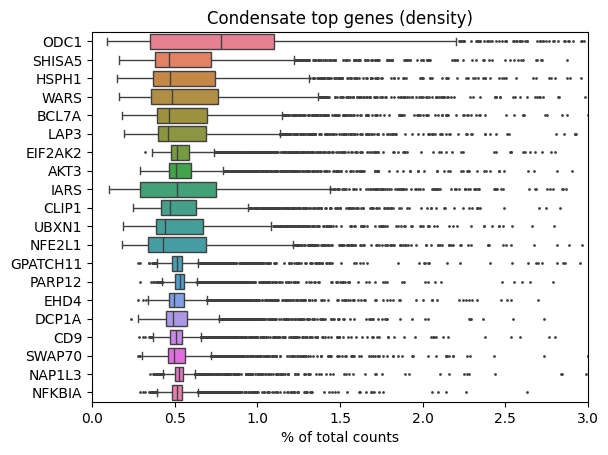

In [3]:
fig, ax = plt.subplots()
ax.set_xlim(0, 3)
ax.set_title("Condensate top genes (density)")
sc.pl.highest_expr_genes(cond_adata, n_top=20, ax=ax)

# Load cytoplasm density data

- plot highest density genes
- ignore x-axis

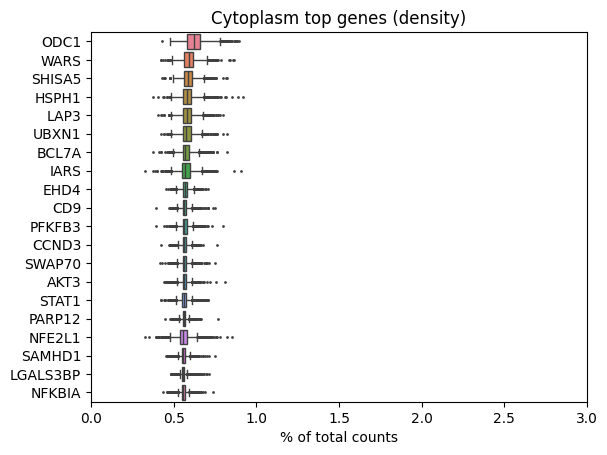

In [4]:
cyto_adata = sc.read("/mnt/d/ebola/data/cytoplasm_density.h5ad")
fig, ax = plt.subplots()
ax.set_xlim(0, 3)
ax.set_title("Cytoplasm top genes (density)")
sc.pl.highest_expr_genes(cyto_adata, n_top=20, ax=ax)


# Load combined density data for basic comparative analysis

In [4]:
adata = sc.read("/mnt/d/ebola/data/combined_density.h5ad")
adata

AnnData object with n_obs × n_vars = 4916 × 180
    obs: 'cell', 'cell_area', 'cell_count', 'compartment'

In [5]:
adata.to_df().mean(axis=1).sort_values(ascending=False)

297     1.412388
1340    1.345788
1918    1.311830
625     1.245544
2411    1.241623
          ...   
185     0.931077
494     0.930021
902     0.929676
688     0.920157
520     0.917232
Length: 4916, dtype: float64

In [8]:
import spatialdata as sd

sdata = sd.read_zarr("/mnt/d/ebola/data/24hpt_manual_processed.zarr/")
sdata

AssertionError: 

In [ ]:
bt.tl.analyze_shapes(
    sdata,
    shape_keys=["small_condensates", "cytoplasm"],
    feature_names=["density"],
    recompute=True,
)

In [3]:
adata.layers['density'] = adata.X.copy()

## Goal: show difference in density between compartments more clearly
> plot normalized density (compartment specific density normalized to cell density) and compare Cytoplasm vs Condensate side by side. So the value and mean difference are not too small to appreciate

In [17]:
adata

AnnData object with n_obs × n_vars = 4916 × 180
    obs: 'cell', 'cell_area', 'cell_count', 'compartment'

In [6]:
density_long = (
    adata.to_df()
    .groupby(adata.obs["compartment"])
    .apply(lambda x: x.mean(axis=1))
    .reset_index()
    .melt(id_vars="compartment")
)
density_long = density_long.rename(columns={"variable": "cell", "value": "density"})

In [16]:
density_long

,compartment,cell,density,log_density_ratio
0,condensate,0,1.000348,1.000251
1,cytoplasm,0,0.999747,0.999817
2,condensate,1,1.001483,1.001069
3,cytoplasm,1,1.003208,1.002312
4,condensate,2,1.013240,1.009519
...,...,...,...,...
4911,cytoplasm,2455,1.001586,1.001144
4912,condensate,2456,1.022016,1.015794
4913,cytoplasm,2456,1.006240,1.004494
4914,condensate,2457,1.021922,1.015728


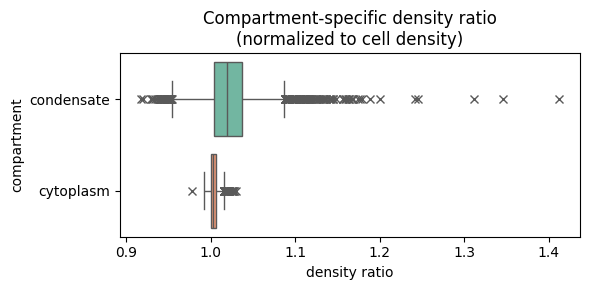

In [67]:
plt.figure(figsize=(6, 3))
sns.boxplot(
    data=density_long,
    y="compartment",
    x="density",
    hue="compartment",
    width=0.8,
    palette="Set2",
    flierprops={"marker": "x"},
)
plt.xlabel("density ratio")
plt.title("Compartment-specific density ratio\n(normalized to cell density)")
plt.tight_layout()


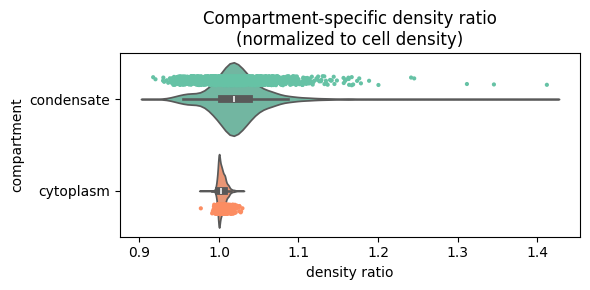

In [90]:
plt.figure(figsize=(6, 3))
sns.violinplot(
    data=density_long,
    y="compartment",
    x="density",
    hue="compartment",
    width=0.8,
    palette="Set2",
)
sns.stripplot(
    data=density_long,
    y="compartment",
    x="density",
    hue="compartment",
    s=3,
    c='black',
    dodge=True,
    jitter=0.1,
    palette="Set2",
    alpha=1,
)
plt.xlabel("density ratio")
plt.title("Compartment-specific density ratio\n(normalized to cell density)")
plt.tight_layout()


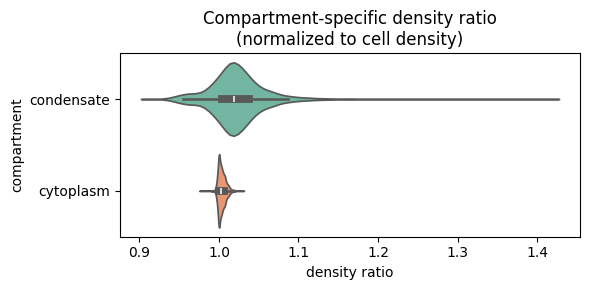

In [91]:
plt.figure(figsize=(6, 3))
sns.violinplot(
    data=density_long,
    y="compartment",
    x="density",
    hue="compartment",
    width=0.8,
    palette="Set2",
)

plt.xlabel("density ratio")
plt.title("Compartment-specific density ratio\n(normalized to cell density)")
plt.tight_layout()


# Differential density analysis

Find genes whose density changes between compartments
- use wilcoxon rank-sum test (probably better way to do this)

In [61]:
sc.tl.rank_genes_groups(adata, groupby='compartment', method='wilcoxon')

In [62]:
sc.get.rank_genes_groups_df(adata, 'condensate')

,names,scores,logfoldchanges,pvals,pvals_adj
0,ODC1,16.392378,1.051362,2.167922e-60,5.912514e-60
1,Blank-30,-1.742319,0.000794,8.145266e-02,8.145266e-02
2,SIGLEC1,-3.531155,0.008520,4.137489e-04,4.160603e-04
3,Blank-34,-3.612503,-0.002601,3.032557e-04,3.066630e-04
4,PSMB8,-3.680254,0.003916,2.330016e-04,2.369507e-04
...,...,...,...,...,...
175,CCDC92,-34.599854,0.023922,2.539408e-262,9.141868e-261
176,MAP3K5,-34.745094,0.015729,1.643921e-264,7.397647e-263
177,PML,-34.950455,0.017267,1.274398e-267,7.646390e-266
178,HERC5,-34.980576,0.017605,4.442130e-268,3.997917e-266


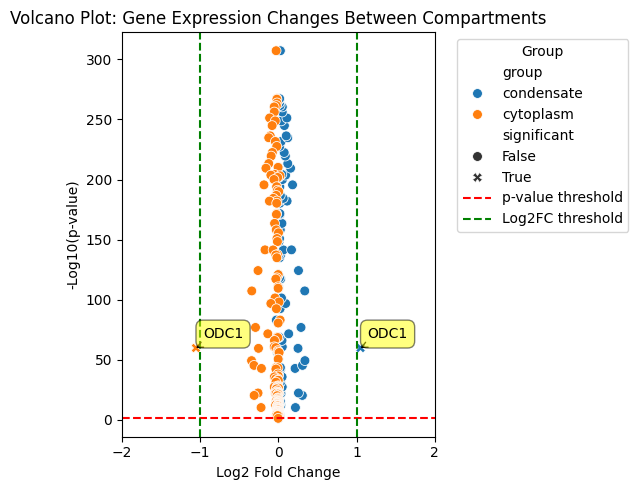

Number of significant genes per group:
group
condensate    1
cytoplasm     1
dtype: int64

Top 5 up-regulated genes in condensate:
        gene    log2fc           pval
0       ODC1  1.051362   2.167922e-60
109    BCL7A  0.341094   6.969653e-50
128  EIF2AK2  0.338482  6.207901e-108
108   SHISA5  0.309850   6.465773e-46
75     HSPH1  0.308054   6.688275e-21

Top 5 down-regulated genes in condensate:
       gene    log2fc           pval
152   OTUD3 -0.005977  1.147358e-190
126  BTN3A3 -0.009010   9.965451e-99
111  ANXA2R -0.011310   1.225397e-56
158   MOV10 -0.021931  7.354379e-204
123    SAT1 -0.024151   1.084511e-83

Top 5 up-regulated genes in cytoplasm:
      gene    log2fc           pval
56    SAT1  0.024151   1.084511e-83
21   MOV10  0.021931  7.354379e-204
68  ANXA2R  0.011310   1.225397e-56
53  BTN3A3  0.009010   9.965451e-99
27   OTUD3  0.005977  1.147358e-190

Top 5 down-regulated genes in cytoplasm:
        gene    log2fc           pval
104    HSPH1 -0.308054   6.688275e-21
71

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Extract results from rank_genes_groups
results = adata.uns['rank_genes_groups']
groups = results['names'].dtype.names

# Create a DataFrame to store the results
volcano_data = pd.DataFrame()

for group in groups:
    temp_df = pd.DataFrame({
        'gene': results['names'][group],
        'log2fc': results['logfoldchanges'][group],
        'pval': results['pvals'][group],
        'group': group
    })
    volcano_data = pd.concat([volcano_data, temp_df])

# Calculate -log10(pvalue)
volcano_data['-log10pval'] = -np.log10(volcano_data['pval'])

# Add a column to color significant genes
volcano_data['significant'] = (volcano_data['pval'] < 0.05) & (abs(volcano_data['log2fc']) > 1)

# Create the volcano plot
plt.figure(figsize=(6, 5))
plt.xlim(-2, 2)
sns.scatterplot(data=volcano_data, x='log2fc', y='-log10pval', hue='group', style='significant', s=50)

plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10(p-value)')
plt.title('Volcano Plot: Gene Expression Changes Between Compartments')

# Add a horizontal line for p-value threshold
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p-value threshold')

# Add vertical lines for log2fc thresholds
plt.axvline(x=1, color='green', linestyle='--', label='Log2FC threshold')
plt.axvline(x=-1, color='green', linestyle='--')

plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels for some top genes (optional)
top_genes = volcano_data[volcano_data['significant']].nlargest(10, '-log10pval')
for _, gene in top_genes.iterrows():
    plt.annotate(gene['gene'], (gene['log2fc'], gene['-log10pval']), xytext=(5, 5), 
                 textcoords='offset points', ha='left', va='bottom', 
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

# Add a summary of significant genes
significant_counts = volcano_data[volcano_data['significant']].groupby('group').size()
print("Number of significant genes per group:")
print(significant_counts)

# Display top 5 up-regulated and down-regulated genes for each group
for group in groups:
    group_data = volcano_data[volcano_data['group'] == group].sort_values('log2fc', ascending=False)
    print(f"\nTop 5 up-regulated genes in {group}:")
    print(group_data.head()[['gene', 'log2fc', 'pval']])
    print(f"\nTop 5 down-regulated genes in {group}:")
    print(group_data.tail()[['gene', 'log2fc', 'pval']])


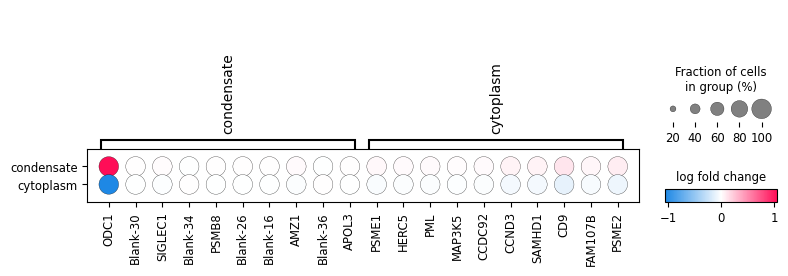

In [64]:
sc.pl.rank_genes_groups_dotplot(adata, groupby='compartment', cmap=bt.colors.red2blue, values_to_plot='logfoldchanges')


In [65]:
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1.0")
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_0.5")
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_0.1")


In [66]:
coef = adata.to_df()
genes_sorted = coef.mean().sort_values(ascending=False).index.tolist()[:50]

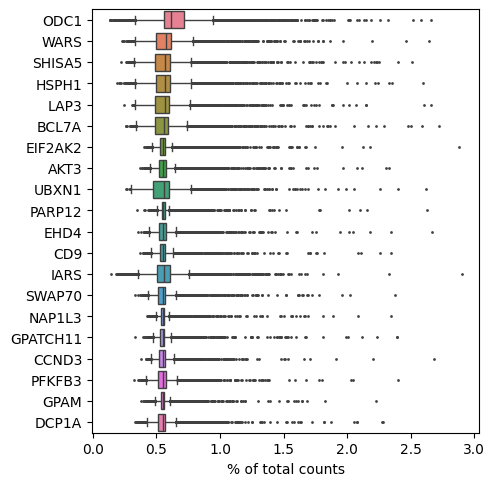

In [67]:
sc.pl.highest_expr_genes(adata, n_top=20)

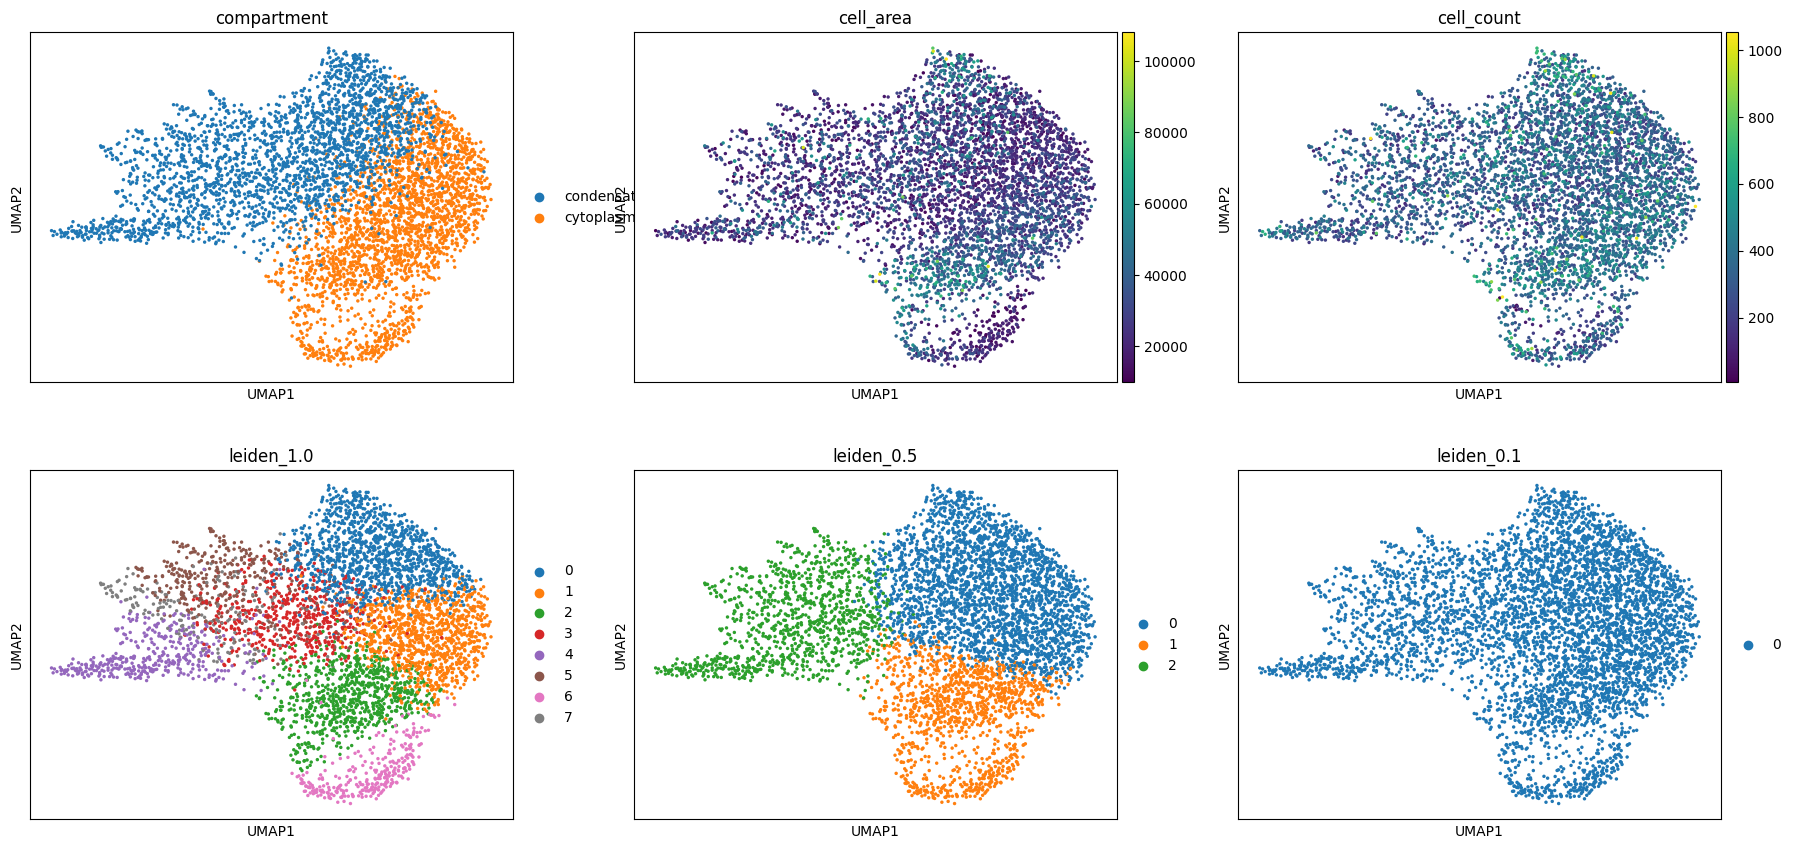

<Figure size 640x480 with 0 Axes>

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "compartment",
        "cell_area",
        "cell_count",
        "leiden_1.0",
        "leiden_0.5",
        "leiden_0.1",
    ],
    ncols=3,
)
plt.tight_layout()

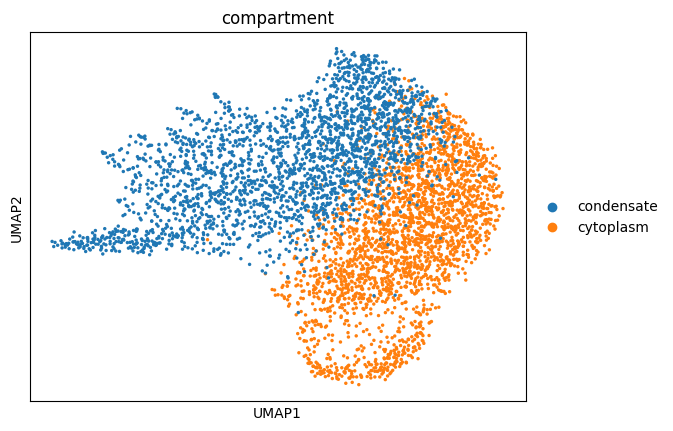

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "compartment",
    ],
    ncols=4,
)

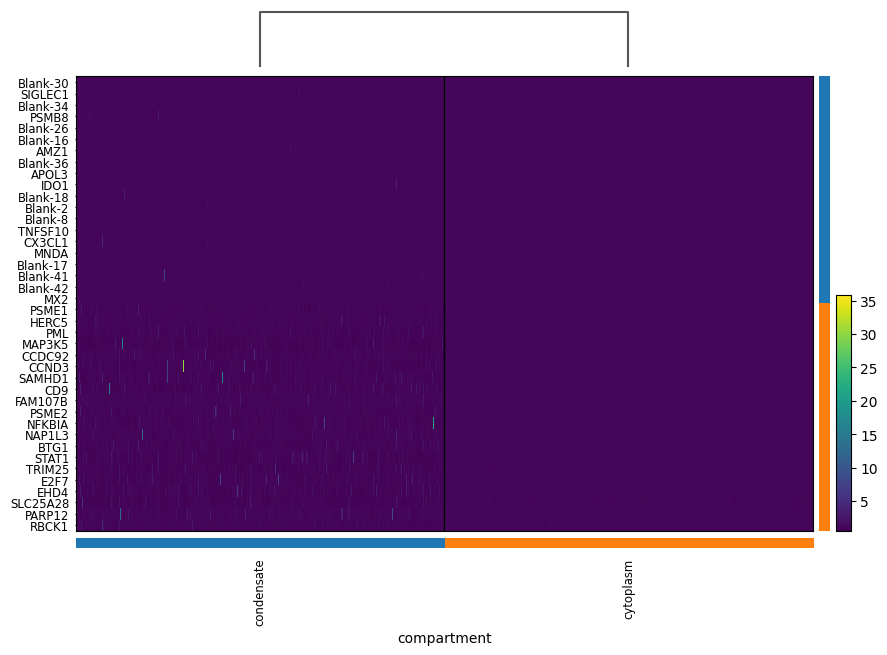

In [50]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=20,
    layer="density",
    swap_axes=True,
    figsize=(10, 7),
    show=False,
);

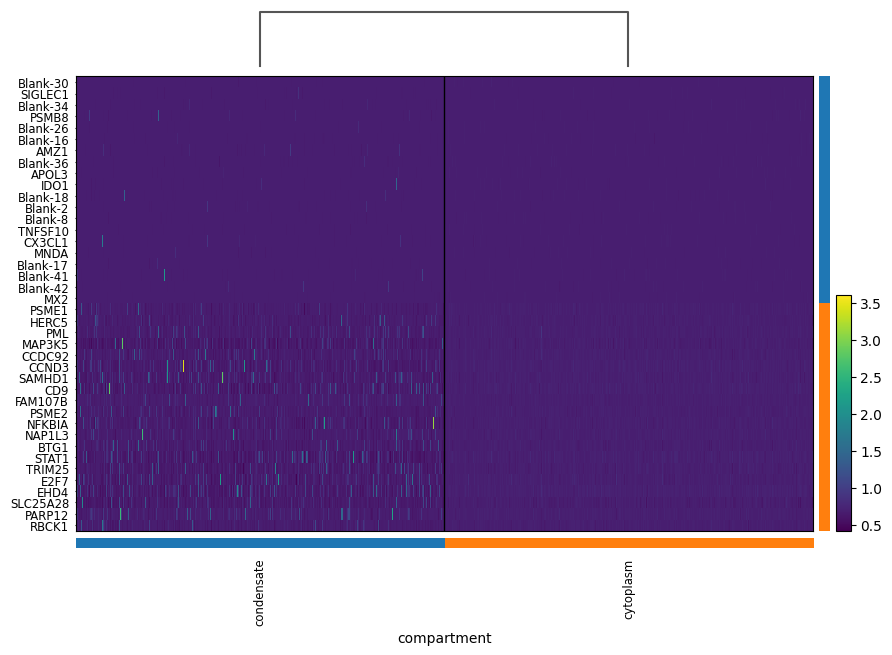

In [51]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=20,
    swap_axes=True,
    figsize=(10, 7),
    show=False,
);